### Minimum Observations

In this simplest example, let's say you have a budget of 60 observations on a spectrograph, and you want to spend them on a single target. How do you best allocate your budget to maximize the Fisher Information on the radial velocity semi-amplitude, K? (In other words, how do you minimize the uncertainty on K?)

In this simplest example, let's say you have a target consisting of planetary system around a single cool, active dwarf. For this example, we'll use AU Mic. Let's say that, given an observing strategy of once per night, we want to know how many observations we would need to achieve a threshold uncertainty on the radial velocity semi-amplitude, K, of 10%. For AU Mic, with a K of 580 cm/s (Klein+ 2021), that means we want the minimum observations needed to reach an uncertainty of 58 cm/s. 

We'll start with the single planet case and then generalize to include both AU Mic b and c. 

In [1]:
import numpy as np 
import scipy
print(np.__version__)
print(scipy.__version__)
import pandas as pd
import random
import exoplanet
import astropy 
import pymc3
import pymc3_ext
import celerite2
from numpy.linalg import inv, det, solve, cond
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib

import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
#from jax import random

1.22.3
1.7.3


In [2]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)

path = '/Users/chrislam/Desktop/scheduling/'

In [3]:
from gaspery import calculate_fi, strategies, utils


In [4]:
### observing parameters
sigma_ks = []
c = 1 # observing cadence of once per day
start = 2352

### target parameters
sigma_wn_rv = 500 # cm/s (from Klein+ 2020)
p = 8.5 # orbital period, days
Prot = 4.86 # rotation period, days
K = 580 # cm/s
T0 = 2360 # arbitrarily chosen fiducial central transit time, in BJD

### correlated noise parameters, from Klein+ 2021 for AU Mic
Tau = 100/np.sqrt(2) # active region lifetime; days
eta = 0.4/np.sqrt(2) # 0.1, 0.3, 0.58, 0.9 # smoothing parameter
sigma_qp_rv = 47 * 1e2 # modified Jeffreys prior +11, -8 [cm/s]
sigma_wn_rv = 5 * 1e2 # [cm/s]

params = [Tau, eta, Prot, sigma_qp_rv, sigma_wn_rv]
theta = [K, p, T0]

for n_obs in tqdm(range(100)[4:]):
    
    # instantiate Strategy class in order to build time series of observations
    strategy = strategies.Strategy(n_obs, c, start, offs=[], dropout=0.)
    
    # build strategy aka time series of observations
    strat = strategy.gappy()

    # build covariance matrix, characterized by a correlated noise model of the stellar signal
    #sigma = np.diag(sigma_wn_rv * np.ones(len(strat)))
    sigma = calculate_fi.cov_matrix_jax(strat, params)
    sigma += 1e-6 

    # populate arguments for Fisher Info calculator
    args = np.array(strat), sigma**2, jnp.array(theta, dtype=float)
    
    # calculate FI
    fim = calculate_fi.clam_jax_fim(*args).block_until_ready()
    
    # invert FI matrix
    inv_fim = inv(fim)
    
    # top left element of matrix corresponds with RV semi-amplitude, K
    sigma_k = np.sqrt(inv_fim)[0][0]
    
    sigma_ks.append(sigma_k)
    

/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_21673/897598058.py:45: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]


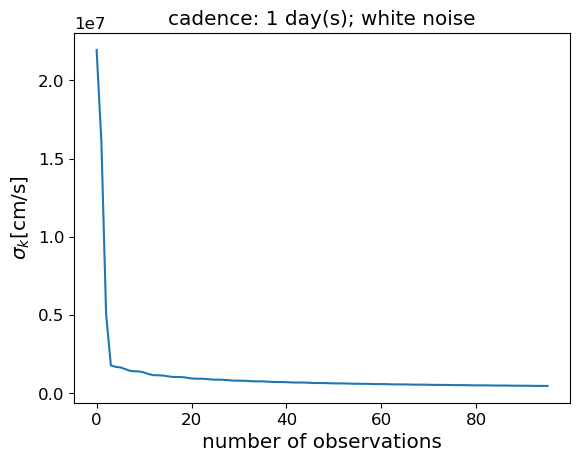

In [5]:
plt.plot(range(len(sigma_ks)), sigma_ks)
#plt.plot(range(len(sigma_k_stable_test)), sigma_k_stable_test, label='not using inv')
plt.xlabel('number of observations')
plt.ylabel(r"$\sigma_k$[cm/s]")
plt.title(f"cadence: {c} day(s); white noise")
#plt.savefig(path + f"plots/au-mic/n_obs.png", format="png")
plt.show()

In [6]:
import celerite2
from celerite2 import terms

# quasiperiodic term
#kernel = terms.SHOTerm(sigma=1., rho=1., tau=10.) # S0=1.0, Q=2.5, w0=0.2
kernel = terms.SHOTerm(sigma=sigma_qp_rv, rho=Prot, tau=Tau)

# set up GP
gp = celerite2.GaussianProcess(kernel, mean=0.)
gp.compute(t, yerr=sigma_wn_rv)
sample = gp.sample(size=50)
mu, sigma = np.mean(sample, axis=0), np.std(sample, axis=0)

for i in strat_phase_folded:
    plt.axvline(i, min(y_phase_folded), max(y_phase_folded), linestyle='--', c='r')
calculate_fi.model_jax(strat, K, p, T0)

plt.plot(t, y, label='planet signal')
plt.fill_between(t, mu - sigma, mu + sigma, alpha=0.2, label='stellar signal')
plt.legend()
plt.xlabel('BJD')
plt.ylabel('RV semi-amplitude [cm/s]')
plt.show()


Array([-213.98785  , -521.316    , -556.5265   , -301.24005  ,
        111.288284 ,  465.7262   ,  577.06323  ,  387.18362  ,
         -4.7989707, -394.27658  , -577.94885  , -459.94214  ,
       -101.853745 ,  309.4004   ,  559.1531   ,  517.0379   ,
        205.03816  , -213.9878   , -521.3161   , -556.52655  ,
       -301.24     ,  111.28808  ,  465.72617  ,  577.06323  ,
        387.1837   ,   -4.7991133, -394.27646  , -577.94885  ,
       -459.94226  , -101.85382  ,  309.40012  ,  559.153    ,
        517.0378   ,  205.03772  , -213.98746  , -521.3159   ,
       -556.5265   , -301.23984  ,  111.28881  ,  465.72595  ,
        577.0633   ,  387.18353  ,   -4.7993164, -394.2762   ,
       -577.9488   , -459.94214  , -101.85362  ,  309.40073  ,
        559.15295  ,  517.03796  ,  205.03804  , -213.98817  ,
       -521.31573  , -556.52625  , -301.2401   ,  111.287384 ,
        465.7264   ,  577.0633   ,  387.18295  ,   -4.798966 ,
       -394.27594  , -577.9489   , -459.94238  , -101.8

### Multi-planet case